In [1]:
import torch

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GATv2Conv

import networkx as nx

### fastRG graph sampling (https://arxiv.org/pdf/1703.02998.pdf)
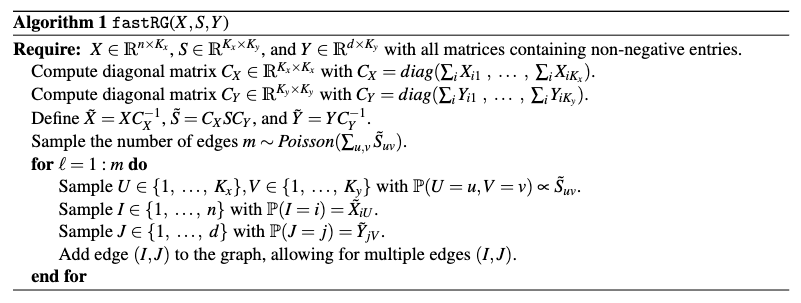

In [2]:
class SBM(dist.TorchDistribution):
    def __init__(self, X, S, Y=None):
        
        # no batch shape given
        if len(X.shape) == 2:
            self.n_nodes, self.n_blocks = X.shape
            batch_shape = torch.Size([])
            
        # batch shape given
        elif len(X.shape) == 3:
            n_batches, self.n_nodes, self.n_blocks = X.shape
            batch_shape = torch.Size([n_batches])
            
        else:
            raise ValueError("X must be 2D or 3D")

        super().__init__(
            batch_shape = batch_shape,
            event_shape = torch.Size([self.n_nodes, self.n_nodes]),
            validate_args=False
        )
        
        # block connection probabilities
        assert S.shape == self.batch_shape + torch.Size([self.n_blocks, self.n_blocks])
        
        # add empty batch dimension if none given
        if len(X.shape) == 2:
            self.X = X.unsqueeze(0)
            self.S = S.unsqueeze(0)
        else:
            self.X = X
            self.S = S
        
        # sink node membership matrix (same as X by default)
        if Y is not None:
            self.Y = Y
            assert self.Y.shape == self.X.shape, "X and Y must have same shape"
            
        else:
            self.Y = self.X
            
        # log expectation matrices
        self.log_expectation = torch.matmul(self.X, torch.matmul(self.S, self.X.transpose(-1,-2))).log()
            
        # membership count matrices (sum along node dimension)
        CX = torch.stack(
            tuple(map(torch.diag, self.X.sum(1)))
        )
        CY = torch.stack(
            tuple(map(torch.diag, self.Y.sum(1)))
        )
        
        # membership probabilitites
        self.Xtilde = torch.matmul(self.X, torch.inverse(CX))
        self.Ytilde = torch.matmul(self.Y, torch.inverse(CY))
                
        # block degree matrix
        self.Stilde = torch.matmul(CX, torch.matmul(self.S, CY))
        
        # distributions
        self.num_edge_dist = dist.Poisson(self.Stilde.sum([1,2]))
        self.block_dist = dist.Multinomial(probs=self.Stilde.flatten(1))
        
        
    def sample(self, sample_shape=torch.Size()):
        
        sample_shape = torch.Size(sample_shape)
        assert len(sample_shape) in [0, 1], "only 0D or 1D sampling supported"

        # number of edges per sample
        num_edges = self.num_edge_dist.sample(sample_shape).int()
        
        if len(sample_shape) == 0:
            num_edges = num_edges.unsqueeze(0)
        
        tot_edges_per_batch = num_edges.sum(0)
        max_edges_per_batch = tot_edges_per_batch.max()
                
        # sample block selections for each edge
        blocks = self.block_dist.sample(max_edges_per_batch.unsqueeze(0))
        
        # create block selection matrices
        blocks = blocks.reshape(
            torch.Size([max_edges_per_batch]) +
            torch.Size([self.batch_shape.numel()]) +
            torch.Size([self.n_blocks]*2)
        )
                
        # select node probabilities for each edge
        source_probs = torch.matmul(self.Xtilde, blocks).sum(-1)
        sink_probs = torch.matmul(blocks, self.Ytilde.transpose(-1, -2)).sum(-2)
                
        # sample node selections for each edge
        sources = dist.Categorical(source_probs).sample()
        sinks = dist.Categorical(sink_probs).sample()
                
        # construct edge lists for each sample and batch
        coords = []
        for batch_coo in range(self.batch_shape.numel()):
            
            tot_edges = tot_edges_per_batch[batch_coo]
            n_edges = num_edges[:, batch_coo]
            
            # slice out edges for this batch
            edges = torch.stack([
                sources[:tot_edges, batch_coo],
                sinks[:tot_edges, batch_coo]
            ])
            
            # split edges into samples
            edge_lists = torch.split(edges, tuple(n_edges), -1)
            
            # construct 4-D (sample, batch, source, sink) coordinates
            for sample_coo, edge_list in enumerate(edge_lists):
                n = edge_list.shape[-1]
                coords.append(
                    torch.concat([
                        torch.Tensor([sample_coo]).int().expand([1, n]),
                        torch.Tensor([batch_coo]).int().expand([1, n]),
                        edge_list
                    ])
                )
                
        coords = torch.concat(coords, -1)
                
        # remove unused coordinates
        if len(sample_shape) == 0 and len(self.batch_shape) == 0:
            coords = coords[[2,3], :]
        elif len(sample_shape) == 0:
            coords = coords[[1,2,3], :]
        elif len(self.batch_shape) == 0:
            coords = coords[[0,2,3], :]
        
        # construct sparse (n_nodes * n_nodes) adjacency matrices
        return torch.sparse_coo_tensor(
            indices = coords,
            values = torch.ones(coords.shape[-1]),
            size = self.shape(sample_shape)
        )

    def log_prob(self, x):
        
        assert x.layout == torch.sparse_coo, "x must be a sparse coordinate tensor"
        
        assert len(x.shape) in [2,3,4], "invalid x shape"
        
        if len(x.shape) == 2:
            n_i, n_j = x.shape
            n_samples = 1
            n_batches = 1
            
        elif len(x.shape) == 3:
            n_x, n_i, n_j = x.shape
            if n_x == self.batch_shape.numel():
                n_batches = n_x
                n_samples = 1
            else:
                n_batches = 1
                n_samples = n_x
                
        elif len(x.shape) == 4:
            n_samples, n_batches, n_i, n_j = x.shape
            assert n_batches == self.batch_shape.numel(), "x does not match distribution batch shape"
            
        assert n_i == self.n_nodes and n_j == self.n_nodes, "x does not match distribution event shape"
            

        # sort coordinates
        if not x.is_coalesced():
            x = x.coalesce()
        
        coords = x.indices()
        
        # [i,j] -> [1, 1, i, j]
        if len(x.shape) == 2:
            coords = torch.concat([
                torch.zeros(1, coords.shape[-1], dtype=int),
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords
            ])
        
        # [batch, i, j] -> [1, batch, i, j]
        elif len(x.shape) == 3 and n_samples == 1:
            coords = torch.concat([
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords
            ])
        
        # [sample, i, j] -> [sample, 1, i, j]:
        elif len(x.shape) == 3 and n_samples > 1:
            coords = torch.concat([
                coords[[0],:],
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords[[1,2], :]
                
            ])         
        
        # initialize
        scores = torch.zeros([n_samples, n_batches])
        n_edges = torch.zeros([n_samples, n_batches])
        
        current_batch = 0
        current_batch_obs = {}
        
        for sample_coo, batch_coo, source, sink in coords.T:
            
            # when batch changes, clear set of observed edges
            if batch_coo != current_batch:
                current_batch_obs = {}
                current_batch = batch_coo
            
            # only score each edge once
            if not current_batch_obs.get((source, sink)):
                scores[sample_coo, batch_coo] += self.log_expectation[batch_coo, source, sink]
                current_batch_obs[(source, sink)] = True
                
            # count total number of edges
            n_edges[sample_coo, batch_coo] += 1
            
        # add score from poisson distribution
        scores += self.num_edge_dist.log_prob(n_edges)
            
        # remove sample and batch dimensions for single event
        if len(x.shape) == 2:
            scores = scores.squeeze([0,1])
            
        # remove batch dimension for multiple events with no batch shape
        elif len(x.shape) == 3 and len(self.batch_shape) == 0:
            scores = scores.squeeze(1)
            
        # remove sample dimension for multiple events with no sample shape
        elif len(x.shape) == 3 and n_samples == 1:
            scores = scores.squeeze(0)
            
        return scores
            

### Loading / normalizing WADI data

In [3]:
import pandas as pd

In [4]:
wadi_train = pd.read_csv("/home/callistb/WADI/WADI_14days_new.csv")

In [5]:
def min_max_normalize(series):
    series -= series.min()
    series /= series.max()
    return series.fillna(0)

In [6]:
wadi_normed = wadi_train.drop(columns=["Row","Date","Time"]).apply(min_max_normalize)

In [7]:
# data parameters
n_nodes = 127
steps_per_window = 5

# hyperparameters
latent_dim = 64
inter_dim = 64
n_blocks = 5
prior_sparsity = 0.01

In [8]:
wadi_windows = torch.Tensor(
    wadi_normed[:-(len(wadi_normed) % 5)].values.reshape(-1, steps_per_window, n_nodes)
)

### Decoder
converts sampled latent variables into parameters for distribution of observables 

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, inter_dim, steps_per_window):
        super().__init__()
        
        self.gat  = GATv2Conv(latent_dim, inter_dim)
        self.fc   = torch.nn.Linear(inter_dim, steps_per_window)
        self.relu = torch.nn.ReLU()
        
    def forward(self, z_batches, edge_index_batches):
        
        # assume batched data
        n_windows, n_nodes, z_dim = z_batches.shape
        assert edge_index_batches.shape[0] == n_windows
        
        # GATv2Conv expects a single graph, so we convert batches into disconnected components
        combined_edge_index = []
        for i in range(n_windows):
            combined_edge_index.append(
                edge_index_batches[i].coalesce().indices() + (i * n_nodes)
            )
        combined_edge_index = torch.concat(combined_edge_index, -1)
        combined_z = z_batches.reshape(-1, z_dim)
        
        combined_out = self.gat(combined_z, combined_edge_index)
        
        out = self.fc(combined_out)
        
        # [n_windows, n_nodes, steps_per_window]
        out = out.reshape(n_windows, n_nodes, steps_per_window)
        
        # [n_windows, steps_per_window, n_nodes]
        out = out.permute([0, 2, 1])
        
        return out
        
decoder = Decoder(latent_dim, inter_dim, steps_per_window)

### Encoder
converts observed values into parameters for distribution of latent variables

In [ ]:
class Encoder(torch.nn.Module):
    
    def __init__(self, n_nodes, n_blocks, steps_per_window, latent_dim):
        super().__init__()
        
        inp_dim = n_nodes * steps_per_window
        
        self.sbm_X_fc = torch.nn.Linear(inp_dim, n_nodes * n_blocks)
        self.sbm_S_fc = torch.nn.Linear(inp_dim, n_blocks * n_blocks)
        self.latent_loc_fc = torch.nn.Linear(inp_dim, n_nodes * latent_dim)
        self.latent_scale_fc = torch.nn.Linear(inp_dim, n_nodes * latent_dim)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, windows):
        n_windows, steps_per_window, n_nodes = windows.shape
        
        inp = windows.reshape(n_windows, -1)
        
        sbm_X_logits = self.sbm_X_fc(inp).reshape(n_windows, n_nodes, n_blocks)
        sbm_S = self.sigmoid(self.sbm_S_fc(inp)).reshape(n_windows, n_blocks, n_blocks)
        
        latent_loc = self.latent_loc_fc(inp).reshape(n_windows, n_nodes, latent_dim)
        latent_scale = self.relu(self.latent_scale_fc(inp)).reshape(n_windows, n_nodes, latent_dim) + 0.01
        
        return sbm_X_logits, sbm_S, latent_loc, latent_scale
        
encoder = Encoder(n_nodes, n_blocks, steps_per_window, latent_dim)

In [15]:
# register encoder and decoder parameters with pyro
pyro.clear_param_store()
pyro.module("encoder", encoder)
pyro.module("decoder", decoder)

Decoder(
  (gat): GATv2Conv(64, 64, heads=1)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)

### Model
Samples latent variables from prior and uses decoder to generate parameters for sampling observables

In [ ]:
def model(windows):
    # batch of windows
    n_windows, steps_per_window, n_nodes = windows.shape
    
    # uniform prior for block membership
    sbm_X_logits = windows.new_ones(torch.Size([n_windows, n_nodes, n_blocks])) / n_blocks
    
    # sparse uniform prior for block connection probability
    sbm_S = windows.new_zeros(torch.Size([n_windows, n_blocks, n_blocks])) + prior_sparsity

    # unit normal prior for latent code
    latent_loc = windows.new_zeros(torch.Size([n_windows, n_nodes, latent_dim]))
    latent_scale = windows.new_ones(torch.Size([n_windows, n_nodes, latent_dim]))

    # sampling latent variables
    with pyro.plate("ind1", n_windows):
        sbm_X = pyro.sample("sbm_X", dist.OneHotCategorical(sbm_X_logits).to_event(1))
        
    edges = pyro.sample("edges", SBM(sbm_X, sbm_S).to_event(1))
    
    with pyro.plate("ind2", n_windows):
        latents = pyro.sample("latents", dist.Normal(latent_loc, latent_scale).to_event(2))

        # decode latents into parameters for observables ([n_windows, steps_per_window, n_nodes])
        obs_logits = decoder(latents, edges)
        
        # score observable
        pyro.sample("obs", dist.ContinuousBernoulli(obs_logits).to_event(2), obs=windows)
        

### Guide
Uses encoder to generate parameters for sampling latent variables

In [16]:
def guide(windows):
    sbm_X_logits, sbm_S, latent_loc, latent_scale = encoder(windows)
    
    with pyro.plate("ind1", len(windows)):
        sbm_X = pyro.sample("sbm_X", dist.OneHotCategorical(logits = sbm_X_logits).to_event(1))
        
    edges = pyro.sample("edges", SBM(sbm_X, sbm_S).to_event(1))
    
    with pyro.plate("ind2", len(windows)):
        latents = pyro.sample("latents", dist.Normal(latent_loc, latent_scale).to_event(2))
        
    return latents, edges


### SVI
Runs for a few epochs on the first 100 batches of windows. as you can see the ELBO isn't changing much, but that makes sense because the encoder and decoder aren't particularly complicated, and there may still be bugs in the SBM implementation

In [17]:
# learning parameters
lr = 0.1
batch_size = 10

optim = pyro.optim.Adagrad({"lr":lr})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO()) 

losses = []
for epoch in range(3):
    epoch_losses = []
    for i,start in enumerate(range(0, len(wadi_windows), batch_size)):

        loss = svi.step(wadi_windows[start:start+batch_size])
        epoch_losses.append(loss)
        
        if i % 10 == 0:
            print(epoch, i, loss)

        if i == 99:
            break
        
    losses.append(epoch_losses)

0 0 659195.6114501953
0 10 661487.477355957
0 20 662709.7829589844
0 30 662849.143951416
0 40 660115.6351318359
0 50 662968.5512695312
0 60 664747.9582214355
0 70 659239.9008789062
0 80 661831.5497131348
0 90 667744.2149658203
1 0 660961.4881591797
1 10 663218.952331543
1 20 663994.5710449219
1 30 663056.0440063477
1 40 661747.6129150391
1 50 662844.0323486328
1 60 663128.443359375
1 70 663759.8866577148
1 80 665227.2003479004
1 90 664023.5018310547
2 0 659398.5838623047
2 10 666084.5311279297
2 20 665866.5877685547
2 30 661423.8511047363
2 40 657846.5347900391
2 50 661393.2198486328
2 60 661194.8643493652
2 70 661724.1721191406
2 80 662443.9934082031
2 90 663998.6524658203
